# Stokes equation

In this tutorial we present how to solve a three-fields Stokes equation with [PyGeoN](https://github.com/compgeo-mox/pygeon). The unkwons are the vorticity $r$, the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$\mu$ the viscosity, we want to solve the following problem: find $(r, q, p)$ such that
$$
\begin{align*}
&\mu^{-1} r - \nabla \times q = 0 \\
&\nabla \times r + \nabla p = {0} \\
&\nabla \cdot {q} = 0
\end{align*}
$$
with boundary conditions:
$$ 
\begin{align*}
&\nu \times r = 1, \quad
\nu \cdot q = {0},
\quad \text{on } \partial_{top} \Omega
\end{align*}
$$
$$
\begin{align*} 
&p = 0, \quad
\nu \times q = {0},
\quad \text{on } \partial \Omega \setminus \partial_{top} \Omega
\end{align*}
$$
Since the pressure is defined up to a constant, we fix its value in a cell. Other choices can be made.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [ ]:
import os
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

We create now the grid, since we will use linear Lagrange elements for $r$ and Raviart-Thomas for ${q}$ we are restricted to triangles. In this example we consider a bi-dimensional grid, but the presented code will work also in 3d where $r$ is approximated with Nédélec elements.

In [2]:
mesh_size = 0.1
dim = 2

sd = pg.unit_grid(dim, mesh_size, as_mdg=False)
sd.compute_geometry()

We define now the finite element spaces for all the variables.

In [3]:
key = "stokes"

# finite element spaces
rt0 = pg.RT0(key)
l1 = pg.Lagrange1(key)  # pg.Nedelec0
p0 = pg.PwConstants(key)

# build the degrees of freedom
dofs = np.array([l1.ndof(sd), rt0.ndof(sd), p0.ndof(sd)])

With the following code we set the data, in particular the viscosity and the boundary conditions. Since we need to identify each side of $\partial \Omega$ for $r$ and $q$ we need few steps.

In [ ]:
# with the following steps we identify the portions of the boundary
# to impose the boundary conditions
ess_faces = sd.tags["domain_boundary_faces"]
ridge_c = sd.nodes

ess_ridges = np.zeros(sd.num_ridges, dtype=bool)
top_ridges = np.logical_and.reduce(
    (ridge_c[1, :] == 1, ridge_c[0, :] != 0, ridge_c[0, :] != 1)
)

ess_cells = np.zeros(sd.num_cells, dtype=bool)
ess_cells[0] = True

bc_faces = np.zeros(sd.num_faces)
bc_ridges = np.zeros(sd.num_ridges)
bc_ridges[top_ridges] = 1

bc_val = np.hstack((bc_ridges, bc_faces, np.zeros(sd.num_cells)))
bc_ess = np.hstack((ess_ridges, ess_faces, ess_cells))

parameters = {
    pg.SECOND_ORDER_TENSOR: pp.SecondOrderTensor(np.ones(sd.num_cells)),
}
data = pp.initialize_data({}, key, parameters)

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation is given as
$$
\left(
\begin{array}{cc} 
M & -B^\top_r & \\
B_r & & -B^\top_q\\
& B_q &
\end{array}
\right)
\left(
\begin{array}{c} 
r\\
q\\ 
p
\end{array}
\right)
=\left(
\begin{array}{c} 
q_{\partial}\\
p_{\partial}\\ 
0
\end{array}
\right)
$$<br>
where $q_{\partial}$ and $p_{\partial}$ is the vector associated to the flux and pressure boundary contions on the natural boundary of $\partial \Omega$. To construct the saddle-point problem, we rely on the `scipy.sparse` function `bmat`. Once the matrix is created, we also construct the right-hand side containing the boundary conditions.

In [5]:
# construct the local matrices
mass = l1.assemble_mass_matrix(sd, data)
face_mass = rt0.assemble_mass_matrix(sd)
cell_mass = p0.assemble_mass_matrix(sd)

curl = face_mass @ l1.assemble_diff_matrix(sd)
div = cell_mass @ rt0.assemble_diff_matrix(sd)

# assemble the saddle point problem
spp = sps.block_array(
    [
        [mass, -curl.T, None],
        [curl, None, -div.T],
        [None, div, None],
    ],
    format="csc",
)

# assemble the right-hand side
rhs = bc_val

We solve the linear system and extract the three solutions $r$, $q$ and $p$.

In [6]:
# solve the problem
ls = pg.LinearSystem(spp, rhs)
ls.flag_ess_bc(bc_ess, np.zeros(bc_ess.size))
x = ls.solve()

# split the solution into the components
idx = np.cumsum(dofs[:-1])
r, q, p = np.split(x, idx)

Since the computed $r$ and $q$ are one value per ridge and facet, respectively, of the grid, for visualization purposes we project the vorticity and velocity in each cell. We finally export the solution to be visualized by [ParaView](https://www.paraview.org/).

In [7]:
# post process velocity
proj_q = rt0.eval_at_cell_centers(sd)
cell_q = (proj_q @ q).reshape((3, -1))

# post process pressure
proj_p = p0.eval_at_cell_centers(sd)
cell_p = proj_p @ p

# export the solution
folder_name = os.path.join(os.getcwd(), key)
file_name = "sol"

save = pp.Exporter(sd, file_name, folder_name=folder_name)
save.write_vtu([("cell_q", cell_q), ("cell_p", cell_p)], data_pt=[("r", r)])

A representation of the computed solution is given below.

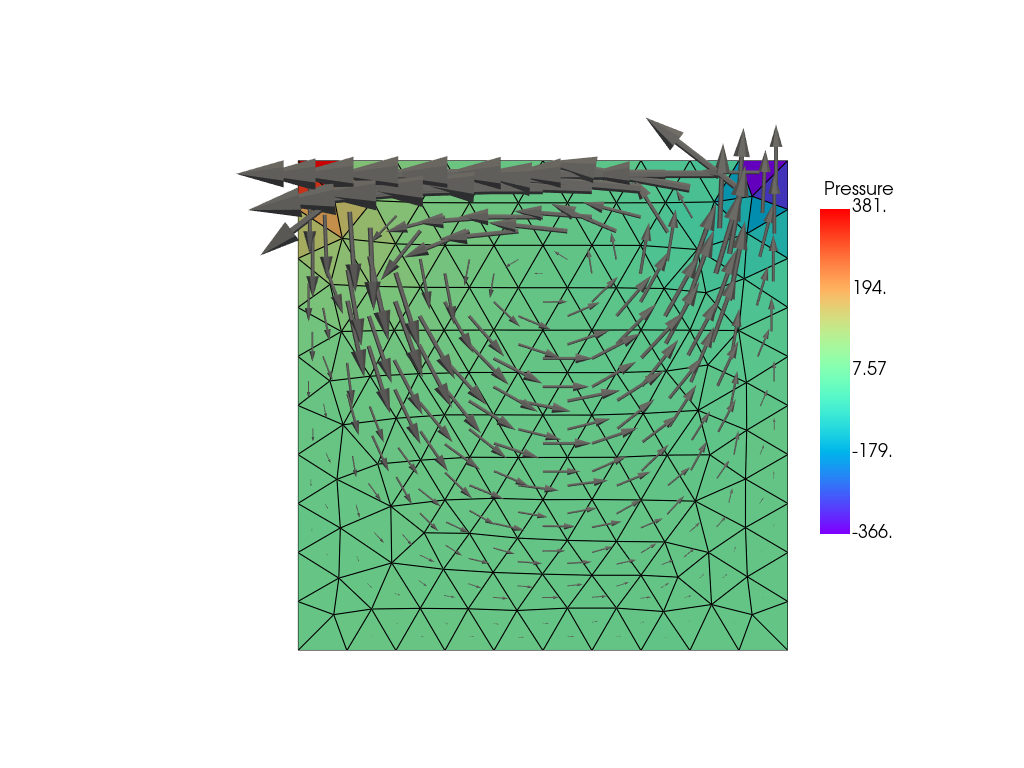

In [ ]:
# NBIGNORE
import pyvista as pv

file_vtu = os.path.join(folder_name, file_name + "_2.vtu")
mesh = pv.read(file_vtu)

plotter = pv.Plotter(off_screen=True, notebook=True)

# Glyphs scaled by magnitude
arrows = mesh.glyph(orient="cell_q", scale="cell_q", factor=0.05)
plotter.add_mesh(arrows, color="gray")

# Mesh colored by rotation
bar = {"title": "Pressure", "vertical": True, "position_x": 0.8, "position_y": 0.3}
plotter.add_mesh(
    mesh, scalars="cell_p", cmap="rainbow", show_edges=True, scalar_bar_args=bar
)

# Show the result
plotter.view_xy()
plotter.enable_parallel_projection()

plotter.show(jupyter_backend="static")


In [10]:
# Consistency check
assert np.isclose(np.linalg.norm(r), 614.3975758651693)
assert np.isclose(np.linalg.norm(q), 3.2864216918908764)
assert np.isclose(np.linalg.norm(p), 3.328621737866961)